In [1]:
%matplotlib inline

import cosima_cookbook as cc
import xarray as xr
import numpy as np
import sys, os

from dask.distributed import Client

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
NYFCntrlDir = '/g/data1/v45/pas561/access-om2_amoc/'
Ocean_File = os.path.join(NYFCntrlDir,'om2_01_amoc_mask.nc')
print(Ocean_File)
cntrl=xr.open_dataset(Ocean_File,engine='netcdf4',decode_times=False)
mask=cntrl.kmu.chunk({'xu_ocean':360,'yu_ocean':270}).rename({'xu_ocean':'grid_xt_ocean', 'yu_ocean':'grid_yu_ocean'})
mask

/g/data1/v45/pas561/access-om2_amoc/om2_01_amoc_mask.nc


<xarray.DataArray 'kmu' (grid_yu_ocean: 2700, grid_xt_ocean: 3600)>
dask.array<shape=(2700, 3600), dtype=float32, chunksize=(270, 360)>
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
Attributes:
    long_name:     number of depth levels on u-grid
    units:         dimensionless
    valid_range:   [-1.e+01  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_c geolat_c

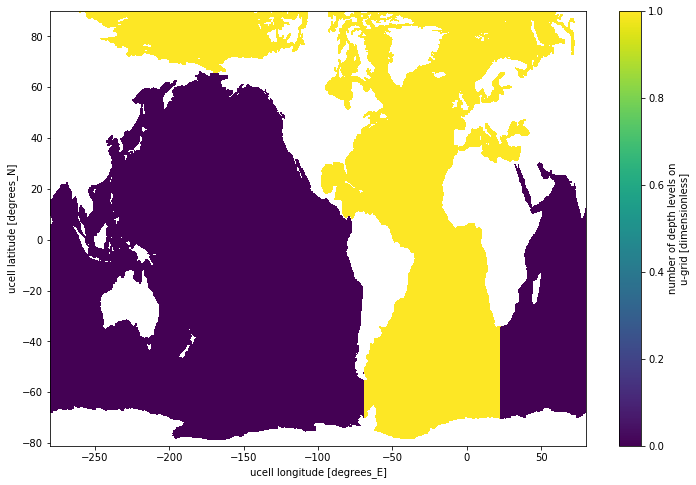

In [3]:
mask.plot(size=8)

In [13]:
expt = '01deg_jra55v13_iaf'
n_files = None                          ## For Testing
time_units = 'days since 0001-01-01'   ## These are to give correct dates
offset = None

psi = cc.get_nc_variable(expt,'ocean.nc','ty_trans_rho',
                                        n=n_files,time_units=time_units, offset=offset)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/compatibility.py:93: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in a future version of xarray. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  return func(*args, **kwargs)


In [14]:
#%time psi = psi.where(mask>0).resample(time='A',skipna=True).mean('time',skipna=True).sum('grid_xt_ocean',skipna=True)*1.0e-9
%time psi_resamp = psi.resample(time='A',skipna=True).mean('time',skipna=True).sum('grid_xt_ocean',skipna=True)*1.0e-9
psi_resamp

CPU times: user 5.42 s, sys: 157 ms, total: 5.57 s
Wall time: 5.56 s


<xarray.DataArray 'ty_trans_rho' (time: 33, potrho: 80, grid_yu_ocean: 2700)>
dask.array<shape=(33, 80, 2700), dtype=float32, chunksize=(1, 8, 270)>
Coordinates:
  * time           (time) datetime64[ns] 1985-12-31 1986-12-31 ... 2017-12-31
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


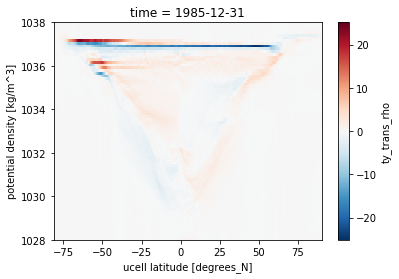

In [15]:
psi_resamp[0,:].plot()

In [ ]:
%time (psi_resamp.cumsum('potrho') -  psi_resamp.sum('potrho')).to_netcdf('AMOC_rho_adv_01deg.nc')

In [9]:
#%time psi_resamp.to_netcdf('psi.nc')

CPU times: user 9min 53s, sys: 3min 47s, total: 13min 40s
Wall time: 6min 50s
